In [1]:
from google.colab import userdata
!pip install -qU "langchain-community>=0.2.11" tavily-python
key = userdata.get('TAVILY_API_KEY')
import subprocess
import os

if not os.environ.get("TAVILY_API_KEY"):
    os.environ["TAVILY_API_KEY"] = key
def check_and_install(package_name):
    try:
        subprocess.check_output(['pip', 'show', package_name])
    except subprocess.CalledProcessError:
        print(f"{package_name} not found, installing...")
        subprocess.check_output(['pip', 'install', package_name])
    else:
        print(f"{package_name} already installed.")

if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')

check_and_install('langchain_community')
check_and_install('langchain')
check_and_install('openai')
check_and_install('python-dotenv')
check_and_install('tiktoken')
check_and_install('langchain_openai')
check_and_install('google-colab')
check_and_install('langgraph')
check_and_install('chromadb')
check_and_install('langchain_experimental')
!pip install --upgrade langchain
!pip install langgraph
!pip install chromadb

oai_key = userdata.get('OPENAI_API_KEY')

Running on CoLab
langchain_community already installed.
langchain already installed.
openai already installed.
python-dotenv already installed.
tiktoken already installed.
langchain_openai already installed.
google-colab already installed.
langgraph already installed.
chromadb already installed.
langchain_experimental already installed.


In [2]:
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
llm = ChatOpenAI(model="gpt-4o-mini", api_key=oai_key)

search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search, max_results=5)

In [9]:
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from pydantic import ValidationError

from pydantic import BaseModel, Field


class Reflection(BaseModel):
    missing: str = Field(description="Critique of what is missing.")
    superfluous: str = Field(description="Critique of what is superfluous")


class AnswerQuestion(BaseModel):
    """Answer the question. Provide an answer, reflection, and then follow up with search queries to improve the answer."""

    answer: str = Field(description="~250 word detailed answer to the question.")
    reflection: Reflection = Field(description="Your reflection on the initial answer.")
    search_queries: list[str] = Field(
        description="1-3 search queries for researching improvements to address the critique of your current answer."
    )


class ResponderWithRetries:
    def __init__(self, runnable, validator):
        self.runnable = runnable
        self.validator = validator

    def respond(self, state: dict):
        response = []
        for attempt in range(3):
            response = self.runnable.invoke(
                {"messages": state["messages"]}, {"tags": [f"attempt:{{attempt}}"]}
            )
            try:
                self.validator.invoke(response)
                return {"messages": response}
            except ValidationError as e:
                state = state + [
                    response,
                    ToolMessage(
                        content=f"{repr(e)}\n\nPay close attention to the function schema.\n\n"
                        + self.validator.schema_json()
                        + " Respond by fixing all validation errors.",
                        tool_call_id=response.tool_calls[0]["id"],
                    ),
                ]
        return {"messages": response}

In [4]:
import datetime

actor_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are expert researcher.
Current time: {time}

1. {first_instruction}
2. Reflect and critique your answer. Be severe to maximize improvement.
3. Recommend search queries to research information and improve your answer.""",
        ),
        MessagesPlaceholder(variable_name="messages"),
        (
            "user",
            "\n\n<system>Reflect on the user's original question and the"
            " actions taken thus far. Respond using the {function_name} function.</reminder>",
        ),
    ]
).partial(
    time=lambda: datetime.datetime.now().isoformat(),
)
initial_answer_chain = actor_prompt_template.partial(
    first_instruction="Provide a detailed ~250 word answer.",
    function_name=AnswerQuestion.__name__,
) | llm.bind_tools(tools=[AnswerQuestion])
validator = PydanticToolsParser(tools=[AnswerQuestion])

first_responder = ResponderWithRetries(
    runnable=initial_answer_chain, validator=validator
)

In [5]:
example_question = "Why is reflection useful in AI?"
initial = first_responder.respond(
    {"messages": [HumanMessage(content=example_question)]}
)

In [6]:
initial

{'messages': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_SfD44Mgj4gf4gkJgoRJueGeq', 'function': {'arguments': '{"answer":"Reflection is a critical component in AI for several reasons. First, it allows AI systems to analyze their own performance and decision-making processes. By evaluating the successes and failures of previous actions, AI can identify patterns that lead to better outcomes. This self-assessment is akin to learning from experience, enabling the system to adapt and improve over time. \\n\\nSecond, reflection facilitates the incorporation of ethical considerations. AI must constantly weigh the ramifications of its actions, whether in terms of data privacy, bias, or the societal impact of its decisions. By reflecting on these aspects, AI can evolve to be more responsible and fair in its operations.\\n\\nAdditionally, reflection enhances transparency in AI systems. When AI can articulate its reasoning and the thought process behind its decisions, it 

In [7]:
revise_instructions = """Revise your previous answer using the new information.
    - You should use the previous critique to add important information to your answer.
        - You MUST include numerical citations in your revised answer to ensure it can be verified.
        - Add a "References" section to the bottom of your answer (which does not count towards the word limit). In form of:
            - [1] https://example.com
            - [2] https://example.com
    - You should use the previous critique to remove superfluous information from your answer and make SURE it is not more than 250 words.
"""


# Extend the initial answer schema to include references.
# Forcing citation in the model encourages grounded responses
class ReviseAnswer(AnswerQuestion):
    """Revise your original answer to your question. Provide an answer, reflection,

    cite your reflection with references, and finally
    add search queries to improve the answer."""

    references: list[str] = Field(
        description="Citations motivating your updated answer."
    )


revision_chain = actor_prompt_template.partial(
    first_instruction=revise_instructions,
    function_name=ReviseAnswer.__name__,
) | llm.bind_tools(tools=[ReviseAnswer])
revision_validator = PydanticToolsParser(tools=[ReviseAnswer])

revisor = ResponderWithRetries(runnable=revision_chain, validator=revision_validator)

In [10]:
import json

revised = revisor.respond(
    {
        "messages": [
            HumanMessage(content=example_question),
            initial["messages"],
            ToolMessage(
                tool_call_id=initial["messages"].tool_calls[0]["id"],
                content=json.dumps(
                    tavily_tool.invoke(
                        {
                            "query": initial["messages"].tool_calls[0]["args"][
                                "search_queries"
                            ][0]
                        }
                    )
                ),
            ),
        ]
    }
)
revised["messages"]

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_57It7hTjh6Dr7k90qbDOrm1x', 'function': {'arguments': '{"answer":"Reflection is essential in artificial intelligence (AI) for promoting improved learning, ethical considerations, and operational transparency. By enabling AI systems to analyze their performance, they can identify successful strategies and areas needing improvement. This adaptive learning process enhances decision-making and performance over time, especially in complex tasks such as reinforcement learning, which relies on evaluating the consequences of actions taken in dynamic environments [1]. \\n\\nMoreover, reflection is crucial for integrating ethical considerations into AI systems. Responsible AI must assess the implications of its actions, such as bias in decision-making or impacts on user privacy, thereby evolving into more trustworthy systems [2]. For instance, chatbots utilizing self-reflection can personalize user interactions while addressing 

In [11]:
revised["messages"].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  ReviseAnswer (call_57It7hTjh6Dr7k90qbDOrm1x)
 Call ID: call_57It7hTjh6Dr7k90qbDOrm1x
  Args:
    answer: Reflection is essential in artificial intelligence (AI) for promoting improved learning, ethical considerations, and operational transparency. By enabling AI systems to analyze their performance, they can identify successful strategies and areas needing improvement. This adaptive learning process enhances decision-making and performance over time, especially in complex tasks such as reinforcement learning, which relies on evaluating the consequences of actions taken in dynamic environments [1]. 

Moreover, reflection is crucial for integrating ethical considerations into AI systems. Responsible AI must assess the implications of its actions, such as bias in decision-making or impacts on user privacy, thereby evolving into more trustworthy systems [2]. For instance, chatbots utilizing self-

In [12]:
from langchain_core.tools import StructuredTool

from langgraph.prebuilt import ToolNode


def run_queries(search_queries: list[str], **kwargs):
    """Run the generated queries."""
    return tavily_tool.batch([{"query": query} for query in search_queries])


tool_node = ToolNode(
    [
        StructuredTool.from_function(run_queries, name=AnswerQuestion.__name__),
        StructuredTool.from_function(run_queries, name=ReviseAnswer.__name__),
    ]
)

In [13]:
from typing import Literal

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict


class State(TypedDict):
    messages: Annotated[list, add_messages]


MAX_ITERATIONS = 5
builder = StateGraph(State)
builder.add_node("draft", first_responder.respond)


builder.add_node("execute_tools", tool_node)
builder.add_node("revise", revisor.respond)
# draft -> execute_tools
builder.add_edge("draft", "execute_tools")
# execute_tools -> revise
builder.add_edge("execute_tools", "revise")

# Define looping logic:


def _get_num_iterations(state: list):
    i = 0
    for m in state[::-1]:
        if m.type not in {"tool", "ai"}:
            break
        i += 1
    return i


def event_loop(state: list):
    # in our case, we'll just stop after N plans
    num_iterations = _get_num_iterations(state["messages"])
    if num_iterations > MAX_ITERATIONS:
        return END
    return "execute_tools"


# revise -> execute_tools OR end
builder.add_conditional_edges("revise", event_loop, ["execute_tools", END])
builder.add_edge(START, "draft")
graph = builder.compile()

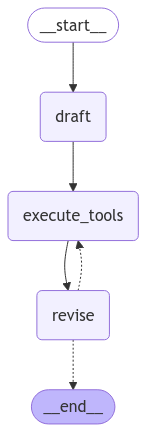

In [14]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [15]:
events = graph.stream(
    {"messages": [("user", "How should we handle the climate crisis?")]},
    stream_mode="values",
)
for i, step in enumerate(events):
    print(f"Step {i}")
    step["messages"][-1].pretty_print()

Step 0
================================ Human Message =================================

How should we handle the climate crisis?
Step 1
================================== Ai Message ==================================
Tool Calls:
  AnswerQuestion (call_fSa6gGRRDsUPwx4BgKk9g4Ym)
 Call ID: call_fSa6gGRRDsUPwx4BgKk9g4Ym
  Args:
    answer: Addressing the climate crisis requires a multifaceted approach that includes international cooperation, policy reforms, technological innovation, and grassroots activism. Firstly, governments need to commit to net-zero emissions targets and implement policies that encourage renewable energy adoption, such as wind, solar, and hydroelectric power. This should be paired with phasing out fossil fuels and reducing subsidies for them. 

Secondly, nations should strengthen international agreements like the Paris Agreement, ensuring that all countries, regardless of development status, set and adhere to ambitious climate targets. Countries could enhance funding